In [16]:
%%javascript
$.getScript('../ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [17]:
from IPython.display import Markdown,display,Math
Markdown('[<< back to chapter content](./content.ipynb)')

[<< back to chapter content](./content.ipynb)

In [18]:
%%HTML
<style>
div.prompt {display:none}
</style>

<div id="toc"></div>

In [19]:
%matplotlib inline
import time
import sys
sys.path.insert(0,'..')
from IPython.display import HTML,Image, SVG, YouTubeVideo
from helpers import show_hide

#Image representation

A digital image is discrete. It means that there is somewhere in the acquisition process, most of the time, sampling that occurs.

A digital image is basically a multidimentionnal array of numbers. Each picture element store a numerical value, with 2D images we speak about **pixels** (from PIcture ELements) and for 3D images we use **voxels** (from VOlume ELements).

The image dimentionnality will depend on:

* the spatial dimentionnality: 1D or profile, 2D image, 3D volume

* the temporal dimension: add one dimension for the time when dealing with **sequences**

* the spectral dimension: the number of spectral values associated with on image element



##Spatial dimensions

The spatial dimension is given, typically, by the grid step of the sensor. A 640x480 CMOS sensor will produce a 640x480 pixels grid.

For a flatbed scanner, one dimension will be given by the number of sensor along the acquisition line, while the second dimension will be given by the spacial repetition of a line acquisition.

One remark concerning these images: the shape of the pixels is not always a square, depending on the sensor geometry and/or the sampling speed (i.e.for the scanners).
One have to pay attention to that, in particular when we will extract measures from images (e.g. distance or surface).




##Temporal dimension



##Spectral dimension


#Information

entropy of a signal is given by:

$$h = -\sum_i {p_i \log {1\over p_i}}$$

where $p_i$ is the probability of occurence of a symbol $i$.

For a gray scale image, one can consider the gray level distribution as the 'probablility' of occurence of a gray level. The following example illustrate how image entropy vary with respect to the graylevel distribution.

If the logarithm base used is 2, the entropy corresponds to the number of bits required to encode the signal.

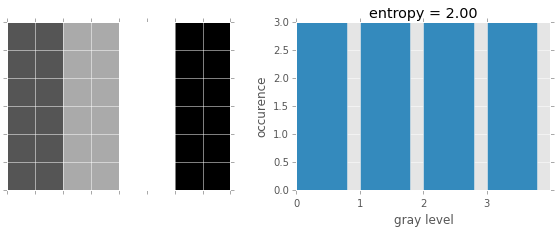

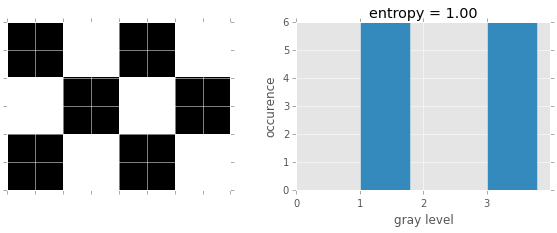

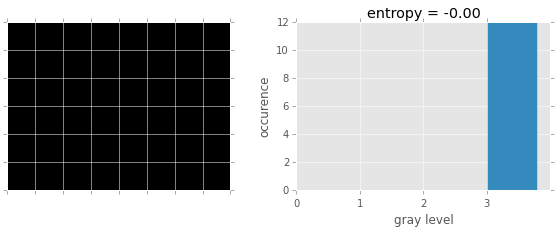

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.data import camera
plt.style.use('ggplot')

def display_hist(ima,nbin):
    hist,bins = np.histogram(ima.flatten(),bins=range(0,nbin+1))
    norm_hist = 1.*hist/np.sum(hist) # normalized histogram
    # entropy
    idx = norm_hist>0
    h = -np.sum(norm_hist[idx]*np.log2(norm_hist[idx]))
    
    # display the results
    plt.figure(figsize=[10,3])
    ax = plt.subplot(1,2,1)
    plt.imshow(ima,cmap=cm.gray,interpolation='nearest')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax = plt.subplot(1,2,2)
    plt.bar(bins[:-1],hist,.8)
    if len(bins)<10:
        ax.set_xticks(bins[:-1])
        ax.set_xticklabels( bins[:-1] )
    plt.xlabel('gray level')
    plt.ylabel('occurence');
    plt.title('entropy = %.2f'%h)
    
    
i1 = np.array([[1,2,3,0],[1,2,3,0],[1,2,3,0]])
i2 = np.array([[1,3,1,3],[3,1,3,1],[1,3,1,3]])
i3 = np.array([[3,3,3,3],[3,3,3,3],[3,3,3,3]])

display_hist(i1,4)
display_hist(i2,4)
display_hist(i3,4)

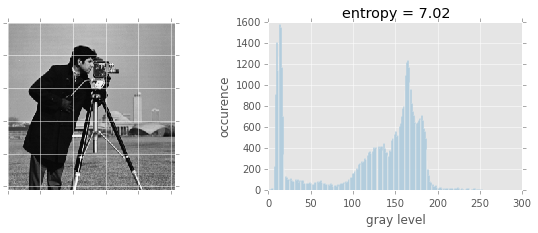

In [6]:
from skimage.data import camera
ima = camera()[::2,::2]
display_hist(ima,255)

The entropy of the above image is 7.05, it means that we need a bit more than 7 bits to encode graylevel for this image. Which is consistent with the choosen data storage (8 bit per pixel). 

Entropy is often known as an information measure.

But what would be the entropy of an image where all the pixels are randomly permuted ?

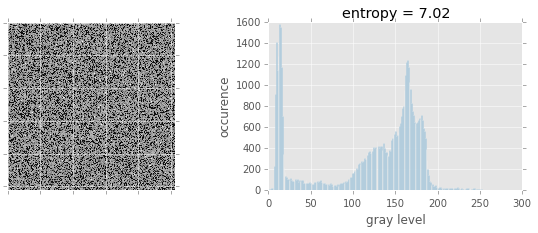

In [7]:
# randomly permutes all the image pixels
d = ima.flatten()
shuffled_ima = np.random.permutation(d.flatten())
shuffled_ima = shuffled_ima.reshape(ima.shape)

display_hist(shuffled_ima,255)

Since the entropy is computed on the graylevel **distribution**, nothing changes. So, from the entropy point of view, information carried by the above image is the same as the one of the cameraman, something about the way we define the information is wrong here...

In fact, when we shuffle the pixels of the image, we lose the localisation information, pixels that where located close to each other are splitted.

In order to take this colocality between pixels, one can use the coocurence matrix.

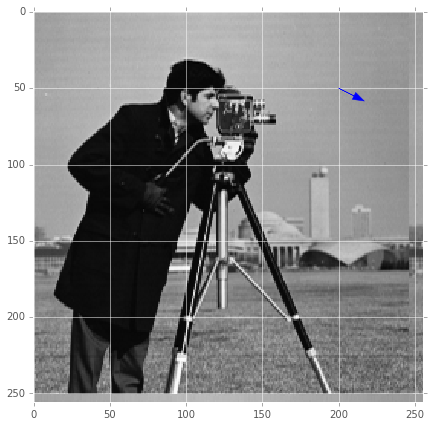

In [8]:
#coocurence matrix

def cooc(im,dx,dy):
    rim = np.roll(im,dy,axis=0)
    rim = np.roll(rim,dx,axis=1)
    G1 = im.flatten()
    G2 = rim.flatten()
    
    histo2D = np.zeros((256,256))

    for g1,g2 in zip(G1,G2):
        histo2D[g1,g2] = histo2D[g1,g2]+1
        
    return histo2D, rim

dx = -10
dy = -5
histo2D,rim = cooc(ima,dx=dx,dy=dy)
plt.figure(figsize=[7,7])
plt.imshow(rim,cmap=cm.gray,interpolation='nearest');
plt.arrow(200,50,-dx,-dy,color='b',head_width=5)

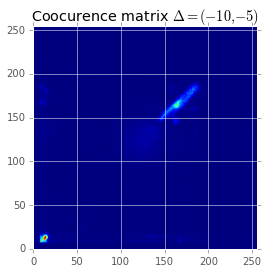

In [9]:
plt.imshow(histo2D)
plt.ylim([0,255])
plt.title('Coocurence matrix $\Delta = (%d,%d)$'%(dx,dy));

What about the impact of our previous shuffling on the coocurence matrix ?

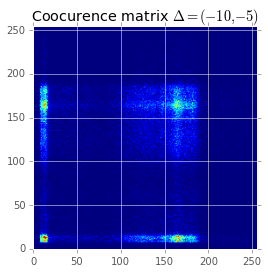

In [10]:
histo2D,_ = cooc(shuffled_ima,dx=dx,dy=dy)
plt.imshow(histo2D)
plt.ylim([0,255])
plt.title('Coocurence matrix $\Delta = (%d,%d)$'%(dx,dy));

An interesting exercice should be to evaluate the entropy of the coocurence matrices of the cameraman image and its shuffled version.


#Compression

##lossless compression
Huffman encoding
run length encoding
image pyramid (compression)

##lossy image compression 
jpeg/dct




#Color representation

##color systems
##color unmixing



In [11]:
print('Last updated: %s' %time.strftime('%d/%m/%Y'))
HTML(show_hide)

Last updated: 20/07/2015
